In [3]:
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from colors import final_color, cv_color
from constants import KINGDOMS
from evaluation.serialization import Serializer

In [55]:
cv_final_metrics = Serializer.load("cv_metrics_per_protein")
final_metrics = Serializer.load("final_metrics_per_protein")

In [59]:
# Preserve label order
final_metrics["label"] = pd.Categorical(final_metrics["label"], ["overall", "NO_SP", "SP", "LIPO", "TAT"])
cv_final_metrics["label"] = pd.Categorical(cv_final_metrics["label"], ["overall", "NO_SP", "SP", "LIPO", "TAT"])

In [62]:
final_data = final_metrics\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    ["value"]

final_data["ci"] = 1.96 * final_data["std"]

In [64]:
cv_average_data = cv_final_metrics\
    .groupby(["metric", "label", "kingdom"])\
    .agg(["mean", "std"])\
    ["value"]

cv_average_data["ci"] = 1.96 * cv_average_data["std"] / 2

In [193]:
k = ["ARCHAEA", "POSITIVE"]
final_data.query("kingdom == 'overall'").sort_values(by="mean")

mean       std        ci
metric    label   kingdom                              
recall    TAT     overall  0.865018  0.033407  0.065477
mcc       SP      overall  0.906145  0.009029  0.017697
recall    SP      overall  0.911325  0.010565  0.020707
mcc       TAT     overall  0.912908  0.020419  0.040021
          LIPO    overall  0.917545  0.012324  0.024154
recall    LIPO    overall  0.921719  0.016294  0.031936
precision overall overall  0.922628  0.009665  0.018944
          LIPO    overall  0.925318  0.014941  0.029284
mcc       overall overall  0.930252  0.006221  0.012193
precision SP      overall  0.931302  0.010131  0.019858
recall    overall overall  0.952161  0.006436  0.012615
mcc       NO_SP   overall  0.953955  0.005265  0.010319
precision TAT     overall  0.968129  0.018184  0.035641
          NO_SP   overall  0.983896  0.002196  0.004305
recall    NO_SP   overall  0.992451  0.001539  0.003017

In [186]:
cv_average_data.query("metric == 'mcc' and kingdom == 'overall'").sort_values(by="mean")

mean       std        ci
metric label   kingdom                              
mcc    TAT     overall  0.853091  0.041154  0.040331
       LIPO    overall  0.882026  0.021325  0.020899
       SP      overall  0.886450  0.014649  0.014356
       overall overall  0.911663  0.011655  0.011422
       NO_SP   overall  0.946894  0.008676  0.008503

In [198]:
final_data.query("metric == 'recall'").sort_values(by="mean")

mean       std        ci
metric label   kingdom                               
recall TAT     EUKARYA   0.000000  0.000000  0.000000
       LIPO    EUKARYA   0.000000  0.000000  0.000000
       TAT     POSITIVE  0.731852  0.095027  0.186253
       SP      POSITIVE  0.802144  0.067848  0.132981
               NEGATIVE  0.812873  0.036834  0.072195
       LIPO    ARCHAEA   0.826530  0.181224  0.355200
       TAT     ARCHAEA   0.860324  0.149035  0.292109
               overall   0.865018  0.033407  0.065477
       overall POSITIVE  0.875051  0.029918  0.058640
               ARCHAEA   0.895801  0.056526  0.110791
       SP      overall   0.911325  0.010565  0.020707
       LIPO    overall   0.921719  0.016294  0.031936
       NO_SP   ARCHAEA   0.922115  0.050830  0.099627
       SP      EUKARYA   0.939100  0.010305  0.020198
       overall NEGATIVE  0.942576  0.010964  0.021490
       NO_SP   POSITIVE  0.946583  0.038288  0.075044
       overall overall   0.952161  0.006436  0.012615
       NO_SP   NEGATIVE  0.963001  0.021446  0.042034
       LIPO    POSITIVE  0.963081  0.020765  0.040699
       overall EUKARYA   0.968973  0.005044  0.009887
       LIPO    NEGATIVE  0.969558  0.012194  0.023900
       TAT     NEGATIVE  0.985023  0.014846  0.029098
       NO_SP   overall   0.992451  0.001539  0.003017
               EUKARYA   0.994517  0.001389  0.002722
       SP      ARCHAEA   1.000000  0.000000  0.000000

## Plot

In [13]:
sns.set_theme()
matplotlib.rcParams.update({"errorbar.capsize": 5})

### By kingdom

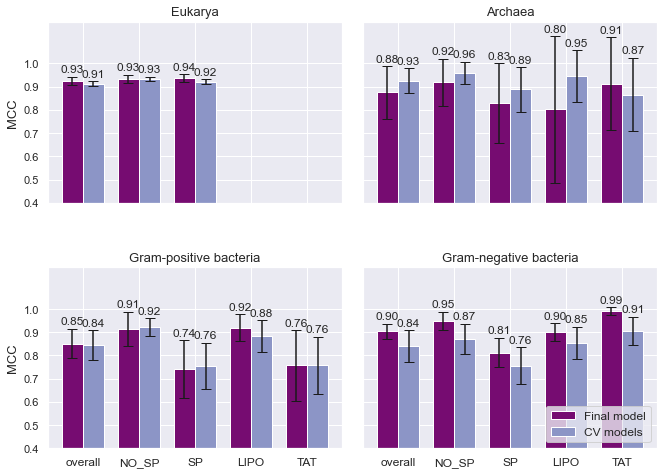

In [202]:
bar_width = 0.38
labels = ["overall", "NO_SP", "SP", "LIPO", "TAT"]
kingdom_labels = {"ARCHAEA": "Archaea", "POSITIVE": "Gram-positive bacteria", "NEGATIVE": "Gram-negative bacteria", "EUKARYA": "Eukarya"}
r1 = np.arange(len(labels))
r2 = r1 + bar_width

fig = plt.figure()
gs = fig.add_gridspec(2,2)

((ax1, ax2), (ax3, ax4)) = gs.subplots(sharex="col", sharey="row")
for ax, kingdom in zip([ax1, ax2, ax3, ax4], KINGDOMS):
    ax.set_title(kingdom_labels[kingdom], fontsize=13)
    final_values = ax.bar(
        r1,
        final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc'")["mean"],
        yerr=final_data.query(f"kingdom == '{kingdom}' and metric == 'mcc'")["ci"],
        width=bar_width,
        color=final_color,
        label="Final model"
    )
    cv_values = ax.bar(
        r2,
        cv_average_data.query(f"kingdom == '{kingdom}' and metric == 'mcc'")["mean"],
        yerr=cv_average_data.query(f"kingdom == '{kingdom}' and metric == 'mcc'")["ci"],
        width=bar_width,
        color=cv_color,
        label="CV models"
    )

    ax.set_ylabel("MCC", fontsize=13)
    ax.set_xticks(r1 + bar_width/2)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylim([0.4, 1.18])
    ax.set_yticks(np.arange(0.4, 1.1, 0.1))
    ax.label_outer()

    ax.bar_label(final_values, padding=2, fmt="%.2f")
    ax.bar_label(cv_values, padding=2, fmt="%.2f")

plt.legend(loc="lower right", fontsize=12)
fig.tight_layout()
fig.set_size_inches(10, 7.5)
fig.savefig("output/rnn_per_protein_performance_by_kingdom.png", dpi=300)

### By pathway

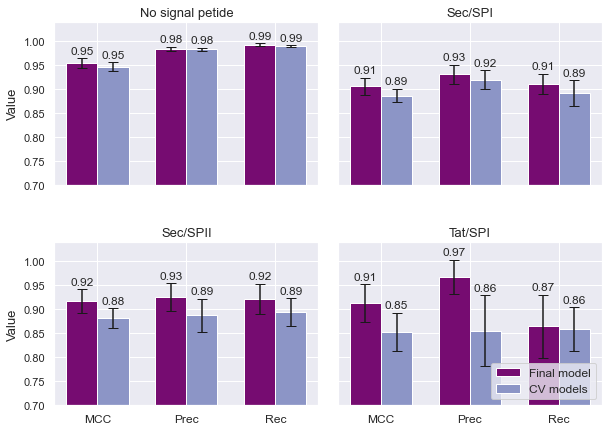

In [201]:
bar_width = 0.35
labels = ["NO_SP", "SP", "LIPO", "TAT"]
plot_labels = {"NO_SP": "No signal petide", "SP": "Sec/SPI", "LIPO": "Sec/SPII", "TAT": "Tat/SPI"}
metrics = ["MCC", "Prec", "Rec"]
r1 = np.arange(len(metrics))
r2 = r1 + bar_width

fig = plt.figure()
gs = fig.add_gridspec(2,2)

((ax1, ax2), (ax3, ax4)) = gs.subplots(sharex="col", sharey="row")
for ax, label in zip([ax1, ax2, ax3, ax4], labels):
    ax.set_title(plot_labels[label], fontsize=13)
    final_values = ax.bar(
        r1,
        final_data.query(f"kingdom == 'overall' and label == '{label}'")["mean"],
        yerr=final_data.query(f"kingdom == 'overall' and label == '{label}'")["ci"],
        width=bar_width,
        color=final_color,
        label="Final model"
    )
    cv_values = ax.bar(
        r2,
        cv_average_data.query(f"kingdom == 'overall' and label == '{label}'")["mean"],
        yerr=cv_average_data.query(f"kingdom == 'overall' and label == '{label}'")["ci"],
        width=bar_width,
        color=cv_color,
        label="CV models"
    )

    ax.set_ylabel("Value", fontsize=13)
    ax.set_xticks(r1 + bar_width/2)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim([0.7, 1.04])
    ax.label_outer()

    ax.bar_label(final_values, padding=2, fmt="%.2f")
    ax.bar_label(cv_values, padding=2, fmt="%.2f")

plt.legend(loc="lower right", fontsize=12)
fig.tight_layout()
fig.set_size_inches(9, 0.75*9)
fig.savefig("output/rnn_per_protein_performance_by_pathway.png", dpi=300)
